In [1]:
import os
from dataclasses import dataclass

import torch
from accelerate import Accelerator
from diffusers import DDIMPipeline, DDIMScheduler, DDPMPipeline, DDPMScheduler, UNet2DModel

In [ ]:
MODEL_PATH = "unconditional_ddpm.pt"

In [2]:
@dataclass
class TrainingConfig:
    image_size = 128
    mixed_precision = "fp16"
    gradient_accumulation_steps = 1
    batch_size = 1
    n_samples = 5
    output_dir = "sampling"


config = TrainingConfig()

In [3]:
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [4]:
model.load_state_dict(torch.load(MODEL_PATH))
model.to("cuda")

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

# DDPM sampling

In [5]:
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    log_with="tensorboard",
    project_dir=os.path.join(config.output_dir, "logs"),
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
ddpm_pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

In [6]:
if not os.path.exists(os.path.join(config.output_dir, "ddpm_samples")):
    os.makedirs(os.path.join(config.output_dir, "ddpm_samples"))
    print(f"Folder '{os.path.join(config.output_dir, 'ddpm_samples')}' created.")
else:
    print(f"Folder '{os.path.join(config.output_dir, 'ddpm_samples')}' already exists.")

Folder 'sampling/ddpm_samples' already exists.


In [7]:
n_generated = 0
ddpm_image_lst = []
while n_generated < config.n_samples:
    images_ddpm = ddpm_pipeline(
        batch_size=config.batch_size,
    ).images
    ddpm_image_lst += images_ddpm
    
    for i, img in enumerate(images_ddpm):
        img.save(os.path.join(config.output_dir, "ddpm_samples", f"{i + 1}.jpg"))

    n_generated += config.batch_size

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

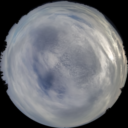

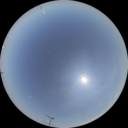

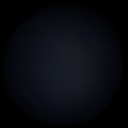

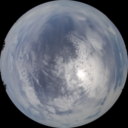

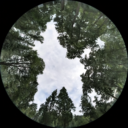

In [8]:
for img in ddpm_image_lst:
    img.show()

# DDIM sampling

In [9]:
ddim_pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

In [10]:
if not os.path.exists(os.path.join(config.output_dir, "ddim_samples")):
    os.makedirs(os.path.join(config.output_dir, "ddim_samples"))
    print(f"Folder '{os.path.join(config.output_dir, 'ddim_samples')}' created.")
else:
    print(f"Folder '{os.path.join(config.output_dir, 'ddim_samples')}' already exists.")

Folder 'sampling/ddim_samples' already exists.


In [11]:
n_generated = 0
ddim_image_lst = []
while n_generated < config.n_samples:
    images_ddim = ddim_pipeline(
        batch_size=config.batch_size,
        num_inference_steps=50
    ).images
    ddim_image_lst += images_ddim
    
    for i, img in enumerate(images_ddpm):
        img.save(os.path.join(config.output_dir, "ddim_samples", f"{i + 1}.jpg"))

    n_generated += config.batch_size

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

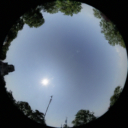

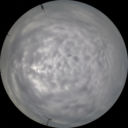

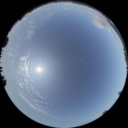

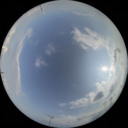

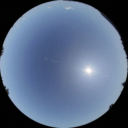

In [12]:
for img in ddim_image_lst:
    img.show()